# Density- Based Clustering

Density-based clustering algorithms assign cluster membership based on proximity to other cluster members. They pursue the goal of identifying dense regions of arbitrary shapes and sizes. They do not require the specification of a certain number of clusters but instead rely on parameters that define the size of a neighborhood and a density threshold.


## Imports & Settings

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline

from time import sleep
from random import shuffle

import numpy as np
from numpy import atleast_2d
import pandas as pd

from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn.metrics import adjusted_mutual_info_score
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_iris
from sklearn.neighbors import KDTree

from hdbscan import HDBSCAN

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib import cm
import matplotlib.ticker as ticker
import seaborn as sns

from IPython import display

In [3]:
cmap = cm.get_cmap('viridis')
cmap = ListedColormap(sns.xkcd_palette(['denim blue', 
                                        'medium green', 
                                        'pale red']))


## Load Iris Data

In [4]:
iris = load_iris()
iris.keys()

dict_keys(['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names', 'filename'])

## Create DataFrame

In [5]:
features = iris.feature_names
data = pd.DataFrame(data=np.column_stack([iris.data, 
                                          iris.target]), 
                    columns=features + ['label'])
data.label = data.label.astype(int)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   sepal length (cm)  150 non-null    float64
 1   sepal width (cm)   150 non-null    float64
 2   petal length (cm)  150 non-null    float64
 3   petal width (cm)   150 non-null    float64
 4   label              150 non-null    int32  
dtypes: float64(4), int32(1)
memory usage: 5.4 KB


### Standardize Data

In [6]:
scaler = StandardScaler()
features_standardized = scaler.fit_transform(data[features])
n = len(data)

### Reduce Dimensionality to visualize clusters

In [7]:
pca = PCA(n_components=2)
features_2D = pca.fit_transform(features_standardized)

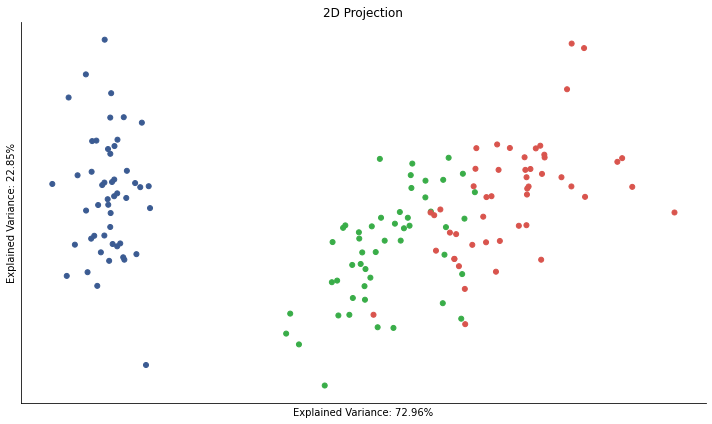

In [8]:
ev1, ev2 = pca.explained_variance_ratio_
ax = plt.figure(figsize=(10, 6)).gca(title='2D Projection', 
                      xlabel=f'Explained Variance: {ev1:.2%}', 
                      ylabel=f'Explained Variance: {ev2:.2%}')
ax.scatter(*features_2D.T, c=data.label, s=25, cmap=cmap)
ax.set_xticklabels([])
ax.set_xticks([])
ax.set_yticklabels([])
ax.set_yticks([])
sns.despine()
plt.tight_layout();

## Perform DBSCAN clustering

Density-based spatial clustering of applications with noise (DBSCAN) has been developed in 1996 and awarded the ‘test of time’ award at the KDD conference 2014 because of the attention it has received in theory an practice. 

It aims to identify core- and non-core samples, where the former extend a cluster and the latter are part of a cluster but do not have sufficient nearby neighbors to further grow the cluster. Other samples are outliers and not assigned to any cluster.

It uses a parameter eps for the radius of the neighborhood and min_samples for the number of members required for core samples. It is deterministic and exclusive and has difficulties with clusters of different density and high-dimensional data. It can be challenging to tune the parameters to the requisite density, especially as it is often not constant.

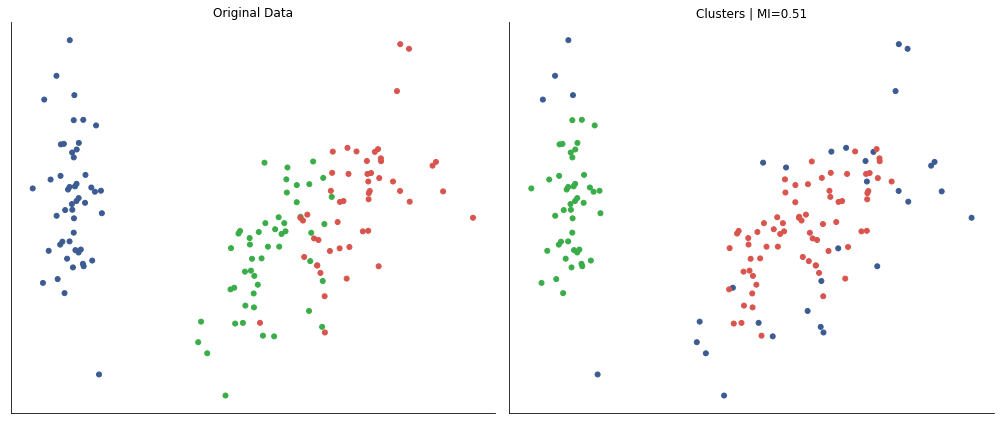

In [9]:
clusterer = DBSCAN()
data['clusters'] = clusterer.fit_predict(features_standardized)
fig, axes = plt.subplots(ncols=2, 
                         figsize=(14, 6))

labels, clusters = data.label, data.clusters
mi = adjusted_mutual_info_score(labels, clusters)

axes[0].scatter(*features_2D.T, c=data.label, s=25, cmap=cmap)
axes[0].set_title('Original Data')
axes[1].scatter(*features_2D.T, c=data.clusters, s=25, cmap=cmap)
axes[1].set_title('Clusters | MI={:.2f}'.format(mi))

for ax in axes:
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
sns.despine()
fig.tight_layout()

### Compare parameter settings

In [10]:
eps_range = np.arange(.2, .91, .05)
min_samples_range = list(range(3, 10))
labels = data.label
mi = {}
for eps in eps_range:
    for min_samples in min_samples_range:
        clusterer = DBSCAN(eps=eps, min_samples=min_samples)
        clusters = clusterer.fit_predict(features_standardized)  
        mi[(eps, min_samples)] = adjusted_mutual_info_score(clusters, labels)

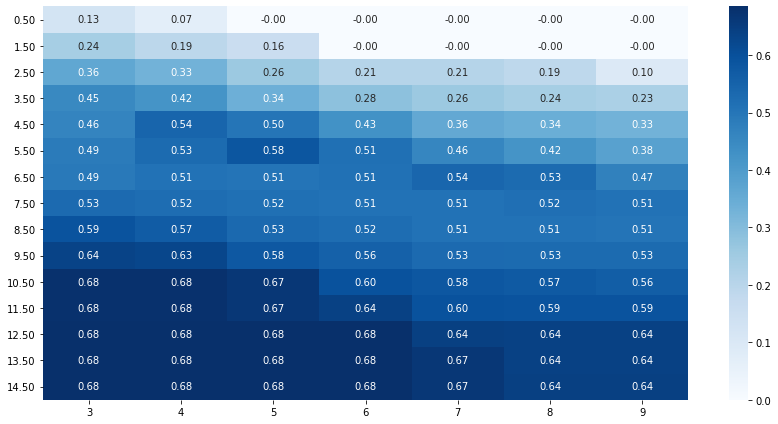

In [11]:
results = pd.Series(mi)
results.index = pd.MultiIndex.from_tuples(results.index)
fig, axes = plt.subplots(figsize=(12, 6))
ax = sns.heatmap(results.unstack(),
                 annot=True,
                 fmt='.2f',
                 cmap='Blues')
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.2f'))
plt.tight_layout()

### Run again

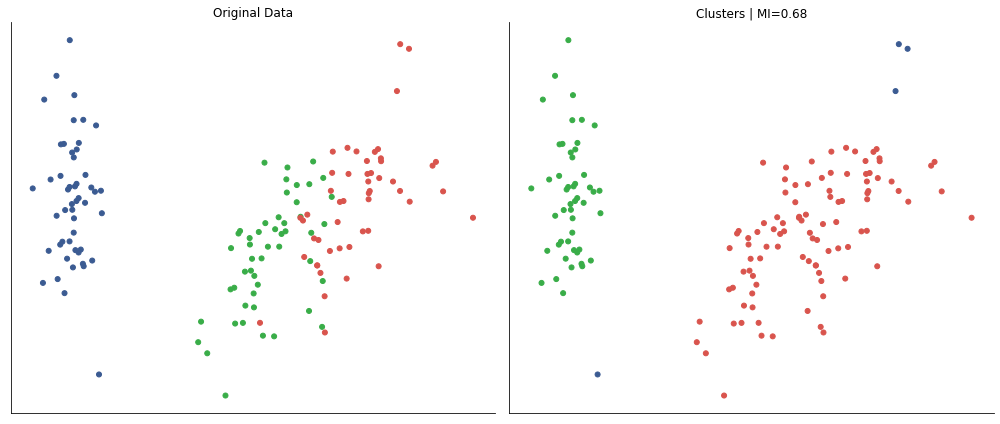

In [12]:
clusterer = DBSCAN(eps=.8, min_samples=5)
data['clusters'] = clusterer.fit_predict(features_standardized)

labels, clusters = data.label, data.clusters
mi = adjusted_mutual_info_score(labels, clusters)

fig, axes = plt.subplots(ncols=2, figsize=(14, 6))
axes[0].scatter(*features_2D.T, c=data.label, s=25, cmap=cmap)
axes[0].set_title('Original Data')
axes[1].scatter(*features_2D.T, c=data.clusters, s=25, cmap=cmap)
axes[1].set_title('Clusters | MI={:.2f}'.format(mi))

for ax in axes:
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
sns.despine()
plt.tight_layout()

### DBSCAN in python

#### Recursive dbscan 

In [13]:
def run_dbscan(point, members):
    members.add(point)
    neighbors = kdtree.query_radius(atleast_2d(data_[point]), eps)[0]
    if len(neighbors) < min_samples:
        return members | set(neighbors)
    else:
        for neighbor in set(neighbors) - set(members):
            members.update(run_dbscan(neighbor, members))
    return members

#### Dynamic Plotting 

In [14]:
def plot_dbscan(data, assignments, axes, delay=.5):
    for ax in axes:
        ax.clear()
    xmin, ymin = data[['x', 'y']].min()
    xmax, ymax = data[['x', 'y']].max()
    data.plot.scatter(x='x', y='y', c=data.label,
                      cmap=cmap, s=25,
                      title='Original Data',
                      ax=axes[0],
                      colorbar=False)
    plot_data.clusters = plot_data.index.map(assignments.get)
    db_data = data.fillna(0)[data.clusters.notnull()]
    db_data.plot.scatter(x='x', y='y',
                         cmap=cmap,
                         colorbar=False,
                         xlim=(xmin, xmax),
                         ylim=(ymin, ymax),
                         c=db_data.clusters,
                         s=25,
                         title='DBSCAN', ax=axes[1])

    display.display(plt.gcf())
    display.clear_output(wait=True)
    sleep(delay)

#### DBSCAN Execution 

In [15]:
eps, min_samples = .6, 5
data_ = features_standardized.copy()
kdtree = KDTree(data_)

In [16]:
to_do = list(range(len(data_)))
shuffle(to_do)

In [17]:
plot_data = pd.DataFrame(data=np.c_[features_2D, labels],
                        columns=['x', 'y', 'label']).assign(clusters=np.nan)

In [18]:
n_clusters = 1

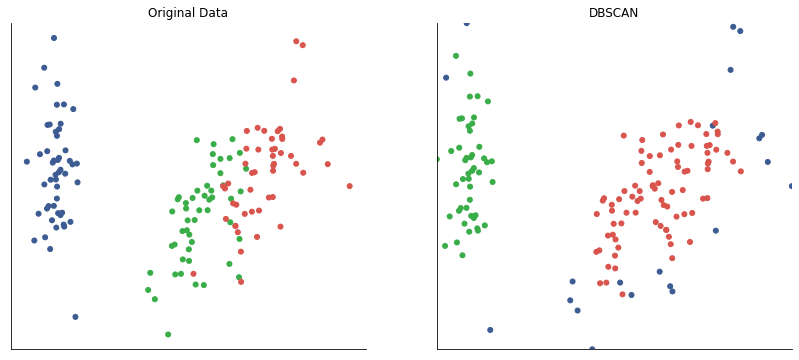

In [19]:
fig, axes = plt.subplots(ncols=2, figsize=(14, 6))
for ax in axes:
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
sns.despine()
    
assignments = {}
while to_do:
    item = to_do.pop()
    neighbors = kdtree.query_radius(atleast_2d(data_[item, :]), eps)[0]
    if len(neighbors) < min_samples:
        assignments[item] = 0
        plot_dbscan(plot_data, assignments, axes)
    else:
        new_cluster = run_dbscan(item, set())
        to_do = [t for t in to_do if t not in new_cluster]
        for member in new_cluster:
            assignments.update({member: n_clusters})
        n_clusters += 1

### HDBSCAN

Hierarchical DBSCAN is a more recent development that assumes clusters are islands of potentially differing density to overcome the DBSCAN challenges just mentioned. It also aims to identify the core and non-core samples. It uses the parameters min_cluster_ size, and min_samples to select a neighborhood and extend a cluster. The algorithm iterates over multiple eps values and chooses the most stable clustering. In addition to identifying clusters of varying density, it provides insight into the density and hierarchical structure of the data.

The following figures show how DBSCAN and HDBSCAN are able to identify very differently shaped clusters.

In [20]:
clusterer = HDBSCAN()
data['clusters'] = clusterer.fit_predict(features_standardized)

labels, clusters = data.label, data.clusters
mi = adjusted_mutual_info_score(labels, clusters)

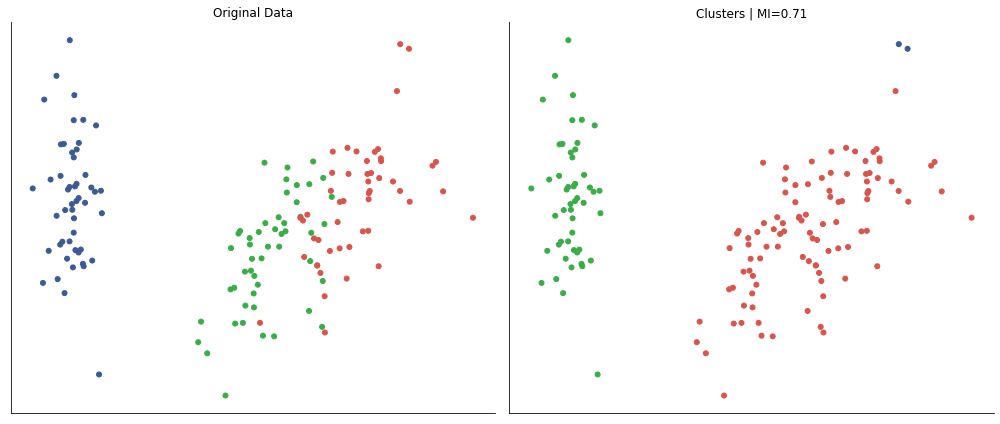

In [21]:
fig, axes = plt.subplots(ncols=2, figsize=(14, 6))

axes[0].scatter(*features_2D.T, c=data.label, s=25, cmap=cmap)
axes[0].set_title('Original Data')
axes[1].scatter(*features_2D.T, c=data.clusters, s=25, cmap=cmap)
axes[1].set_title('Clusters | MI={:.2f}'.format(mi))

for ax in axes:
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
sns.despine()
fig.tight_layout()

### Alternative Dataset 

In [22]:
alternative_data = np.load('clusterable_data.npy')
fig, ax = plt.subplots(figsize=(12, 6))
ax.set_aspect('equal')
ax.scatter(*alternative_data.T, s=20)

ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
sns.despine()
fig.tight_layout()

FileNotFoundError: [Errno 2] No such file or directory: 'clusterable_data.npy'

### Compare DBSCAN & HDBSCAN 

In [ ]:
dbscan = DBSCAN(eps=.02, min_samples=10)
db_clusters = dbscan.fit_predict(alternative_data)

In [ ]:
hdbscan = HDBSCAN(min_cluster_size=15, gen_min_span_tree=True)
hdb_clusters = hdbscan.fit_predict(alternative_data)

In [ ]:
cluster_sizes = pd.DataFrame({'HDBSCAN': pd.Series(hdb_clusters).value_counts(),
                              'DBSCAN': pd.Series(db_clusters).value_counts()})

In [ ]:
cluster_sizes.sort_index(ascending=False).plot.barh(subplots=True,
                                                    layout=(2, 1),
                                                    figsize=(8, 8),
                                                    legend=False)
sns.despine()
plt.tight_layout()

In [ ]:
fig, axes = plt.subplots(ncols=2,
                         figsize=(14, 6))
cmap = ListedColormap(sns.color_palette('Paired',
                                        len(np.unique(db_clusters))))
axes[0].scatter(*alternative_data.T, c=db_clusters, s=10, cmap=cmap)
axes[0].set_title('DBSCAN')
axes[1].scatter(*alternative_data.T, c=hdb_clusters, s=10, cmap=cmap)
axes[1].set_title('HDBSCAN')

for ax in axes:
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
sns.despine()
fig.tight_layout()

### HDBSCAN: Density-based Dendrogram 

In [ ]:
fig, ax = plt.subplots(figsize=(14, 6))
hdbscan.condensed_tree_.plot(select_clusters=True,
                             cmap='Blues',
                             selection_palette=sns.color_palette('Set2', 8))
fig.tight_layout();

### Minimum Spanning Tree

In [ ]:
fig, ax = plt.subplots(figsize=(14, 7))
hdbscan.minimum_spanning_tree_.plot(edge_cmap='Blues',
                                    edge_alpha=0.6,
                                    node_size=20,
                                    edge_linewidth=1)
sns.despine()
fig.tight_layout();